Preliminary Check: are both probes are consistent?

Control Probe             |  Measurement Probe
:-------------------------:|:-------------------------:
![](raw/calibration_control.png)  |  ![](raw/calibration_measured.png)

# Setup - Importing Libraries and Data

In [2]:
import numpy as np
import glob
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [3]:
# Get all Excel files from the raw folder
excel_files = glob.glob('raw/*.xls')
print(excel_files)

excel_file = excel_files[0]

['raw\\11_29_meal_control.xls', 'raw\\11_29_meal_measured.xls', 'raw\\11_29_nv_lounge_control_1.xls', 'raw\\11_29_nv_lounge_measured_1.xls', 'raw\\11_30_nv_lounge_ambient_control.xls', 'raw\\11_30_nv_lounge_ambient_measured.xls', 'raw\\12_1_nv_lounge_live_control.xls', 'raw\\12_1_nv_lounge_live_measured.xls', 'raw\\bc_library_test_rena.xls', 'raw\\nv_lounge_test_zz.xls']


In [4]:
# Read the "List" sheet from the Excel file
df_lists = [pd.read_excel(excel_file, sheet_name='List', index_col="No.", dtype={"Temperature°C": float, "Humidity%RH": float}) for excel_file in excel_files]
for df_list in df_lists:
    df_list.rename(columns={"Temperature°C": "Temperature", "Humidity%RH": "Humidity"}, inplace=True)
    df_list["Time"] = pd.to_datetime(df_list["Time"])

print(len(df_lists))

c:\Users\ongzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\ongzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\ongzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\ongzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl'

10


c:\Users\ongzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
date_format = DateFormatter("%H:%M")

def plot_data(time, temp, humidity, marker='.', xlabel=None, ylabel_temp='Temperature (°C)', ylabel_humidity='Humidity (%RH)', title=None):
    fig, ax1 = plt.subplots(1, 2, figsize=(18, 6))

    # Plot temperature
    ax1[0].plot(time, temp, marker=marker)
    ax1[0].set_xlabel(xlabel)
    ax1[0].set_ylabel(ylabel_temp)
    ax1[0].set_title(f'{title} - Temperature')
    ax1[0].grid(True)
    ax1[0].xaxis.set_major_formatter(date_format)

    # Plot humidity
    ax1[1].plot(time, humidity, marker=marker)
    ax1[1].set_xlabel(xlabel)
    ax1[1].set_ylabel(ylabel_humidity)
    ax1[1].set_title(f'{title} - Humidity')
    ax1[1].grid(True)
    ax1[1].xaxis.set_major_formatter(date_format)

    plt.tight_layout()
    plt.show()

# Analysis - Test Dataset

In [71]:
excel_file = [excel_file for excel_file in excel_files if excel_file == "raw\\bc_library_test_rena.xls"][0]
test_df = df_lists[excel_files.index(excel_file)]
print(excel_file)

raw\bc_library_test_rena.xls


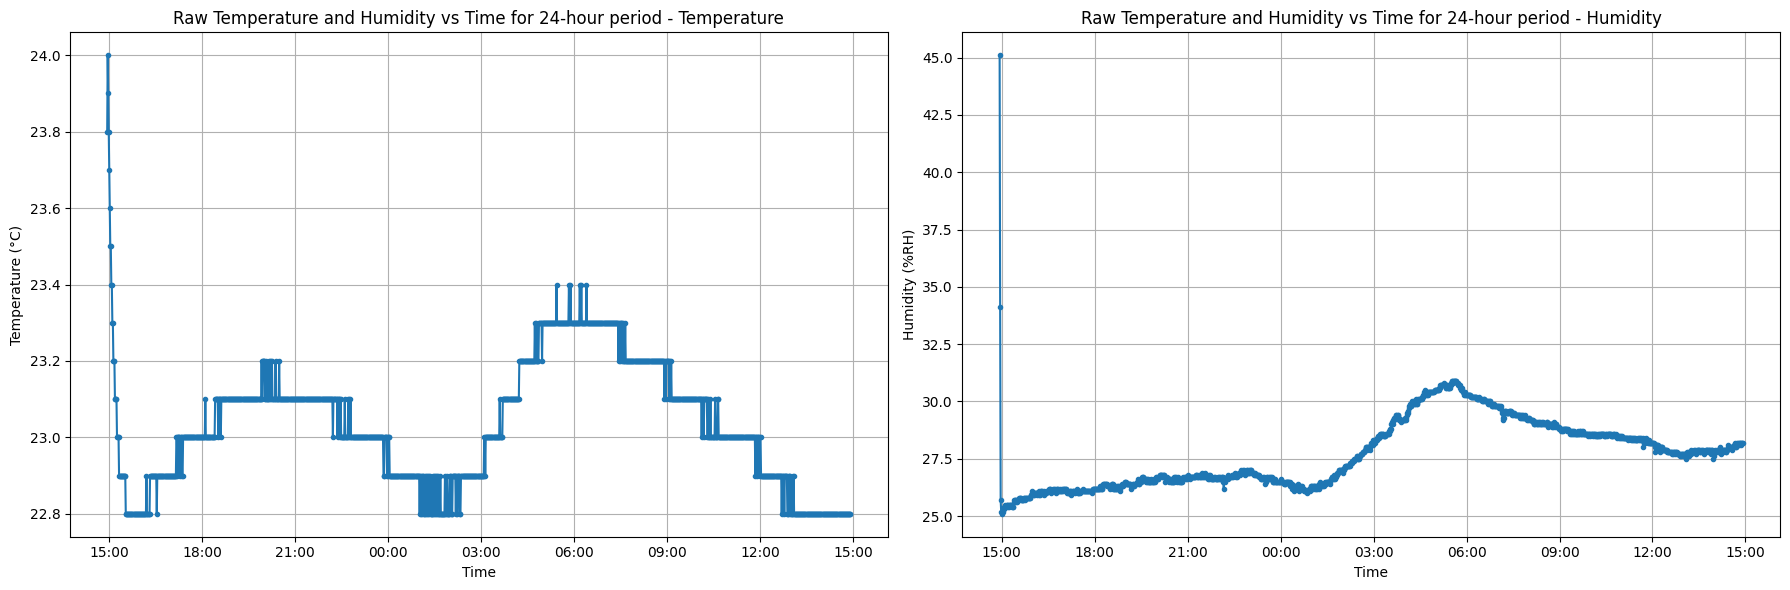

In [72]:
# Filter the dataframe for the 24-hour period from 9am to 9am
start_time = test_df["Time"].iloc[0]
end_time = start_time + pd.Timedelta(hours=24)
df_24h = test_df[(test_df["Time"] >= start_time) & (test_df["Time"] < end_time)]

plot_data(df_24h["Time"], df_24h["Temperature"], df_24h["Humidity"],
          marker='.', xlabel='Time', title='Raw Temperature and Humidity vs Time for 24-hour period')


Data seems noisy, try to remove outliers by IQR method

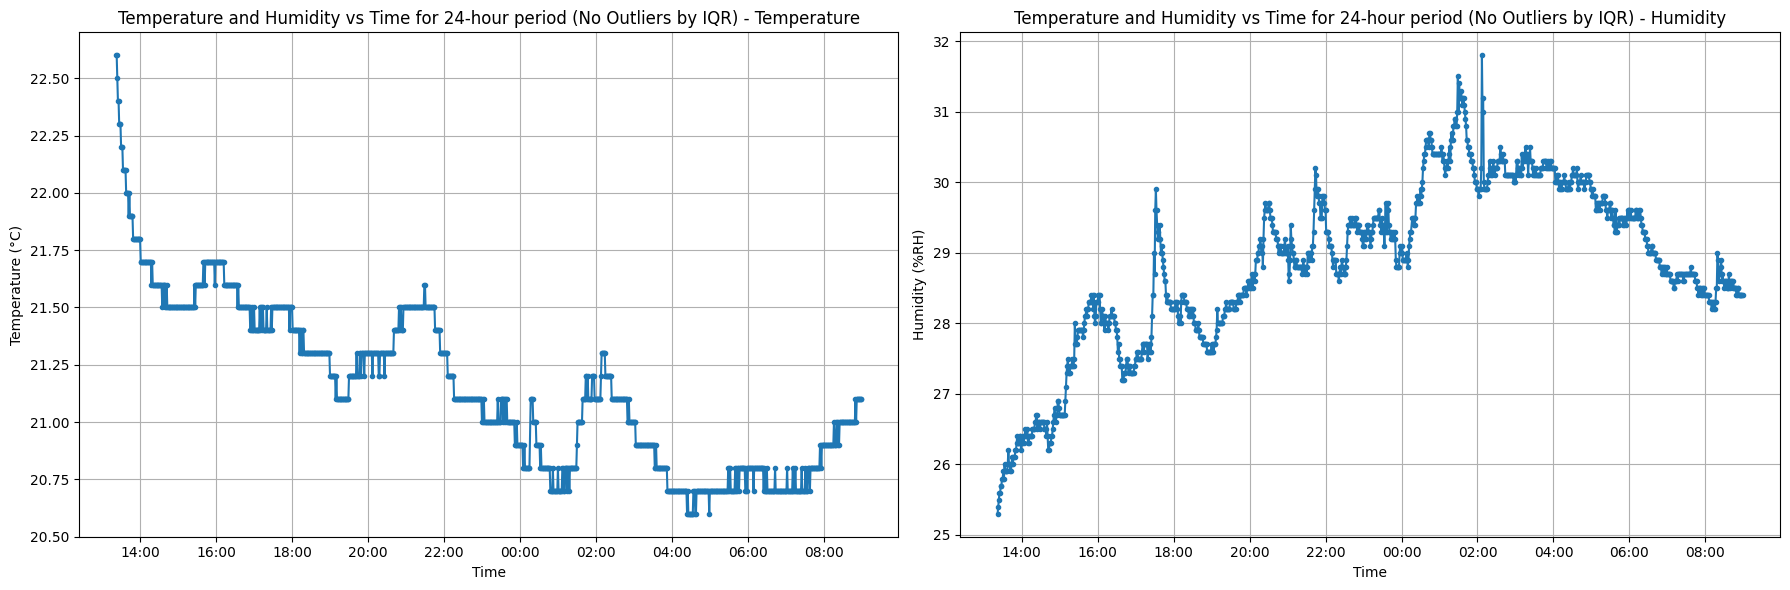

In [8]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for Temperature and Humidity
Q1_temp, Q3_temp = df_24h['Temperature'].quantile([0.25, 0.75])
Q1_humidity, Q3_humidity = df_24h['Humidity'].quantile([0.25, 0.75])
IQR_temp = Q3_temp - Q1_temp
IQR_humidity = Q3_humidity - Q1_humidity

# Define outlier criteria for Temperature and Humidity
outlier_criteria_temp = (df_24h['Temperature'] < (Q1_temp - 1.5 * IQR_temp)) | (df_24h['Temperature'] > (Q3_temp + 1.5 * IQR_temp))
outlier_criteria_humidity = (df_24h['Humidity'] < (Q1_humidity - 1.5 * IQR_humidity)) | (df_24h['Humidity'] > (Q3_humidity + 1.5 * IQR_humidity))

# Remove outliers for Temperature and Humidity
df_24h_no_outliers = df_24h[~(outlier_criteria_temp | outlier_criteria_humidity)]

# Plot the temperature and humidity vs time without outliers using the plot_data function
plot_data(df_24h_no_outliers["Time"], df_24h_no_outliers["Temperature"], df_24h_no_outliers["Humidity"],
          marker='.', xlabel='Time', title='Temperature and Humidity vs Time for 24-hour period (No Outliers by IQR)')

Alternatively, filter time series data on a rolling window basis if want less extreme filtering

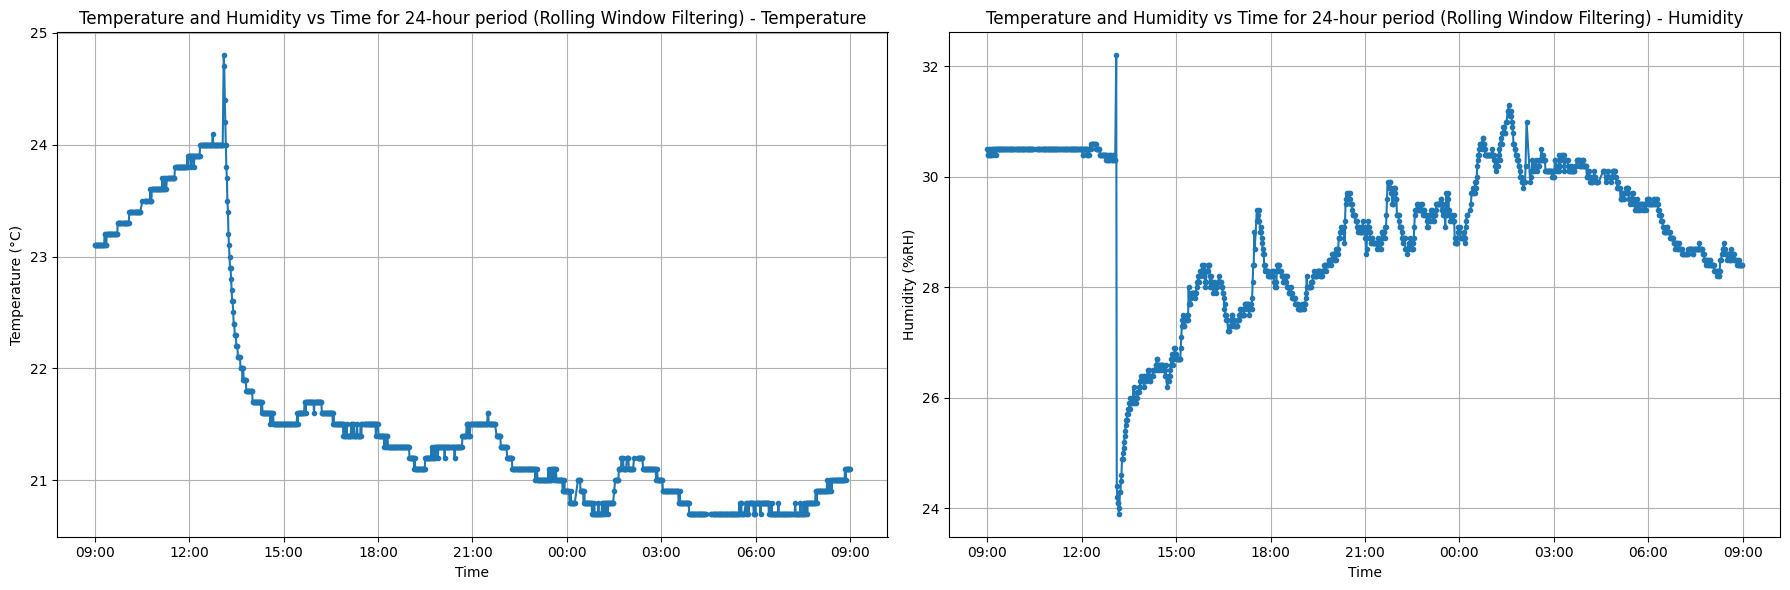

In [9]:
# Define the window size for the rolling statistics
window_size = 60
# Define the threshold for detecting spikes (e.g., 1.96 standard deviations from the mean, 95% CI)
threshold = 1.96

# Calculate the rolling mean and standard deviation for Temperature
rolling_mean_temp = df_24h['Temperature'].rolling(window=window_size, center=True).mean()
rolling_std_temp = df_24h['Temperature'].rolling(window=window_size, center=True).std()

# Calculate the rolling mean and standard deviation for Humidity
rolling_mean_humidity = df_24h['Humidity'].rolling(window=window_size, center=True).mean()
rolling_std_humidity = df_24h['Humidity'].rolling(window=window_size, center=True).std()

# Identify and remove spikes for Temperature
spikes_temp = (df_24h['Temperature'] - rolling_mean_temp).abs() > (threshold * rolling_std_temp)

# Identify and remove spikes for Humidity
spikes_humidity = (df_24h['Humidity'] - rolling_mean_humidity).abs() > (threshold * rolling_std_humidity)

# Remove spikes for both Temperature and Humidity
df_24h_no_spikes = df_24h[~(spikes_temp | spikes_humidity)]

# Plot the temperature and humidity vs time without spikes using the plot_data function
plot_data(df_24h_no_spikes["Time"], df_24h_no_spikes["Temperature"], df_24h_no_spikes["Humidity"],
          marker='.', xlabel='Time', title='Temperature and Humidity vs Time for 24-hour period (Rolling Window Filtering)')


# Analysis - Meal Dataset

raw\11_29_meal_measured.xls raw\11_29_meal_control.xls
997 996
                   Time  Temperature  Humidity
No.                                           
1   2024-11-29 17:40:00         22.3      21.8
2   2024-11-29 17:40:10         22.3      21.8
3   2024-11-29 17:40:20         22.2      21.8
4   2024-11-29 17:40:30         22.2      21.7
5   2024-11-29 17:40:40         22.2      21.7


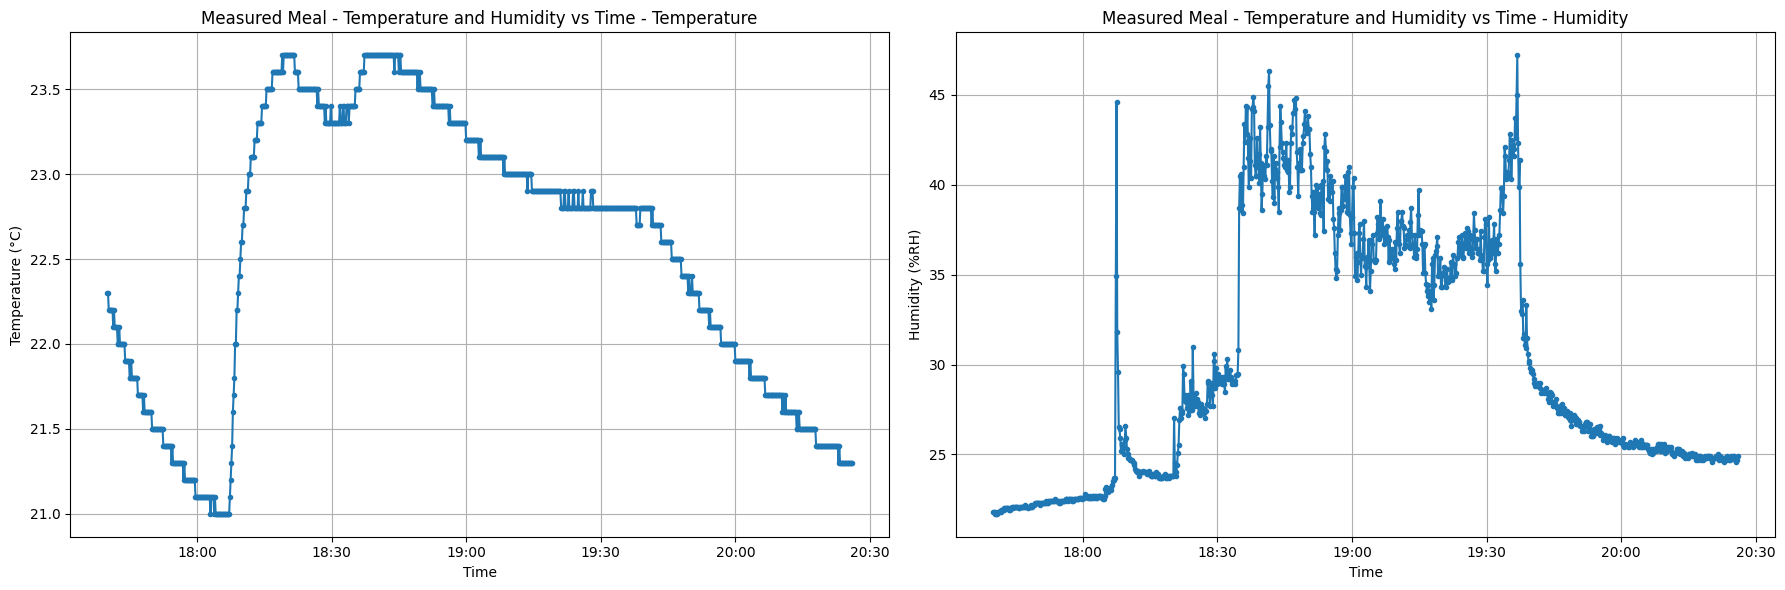

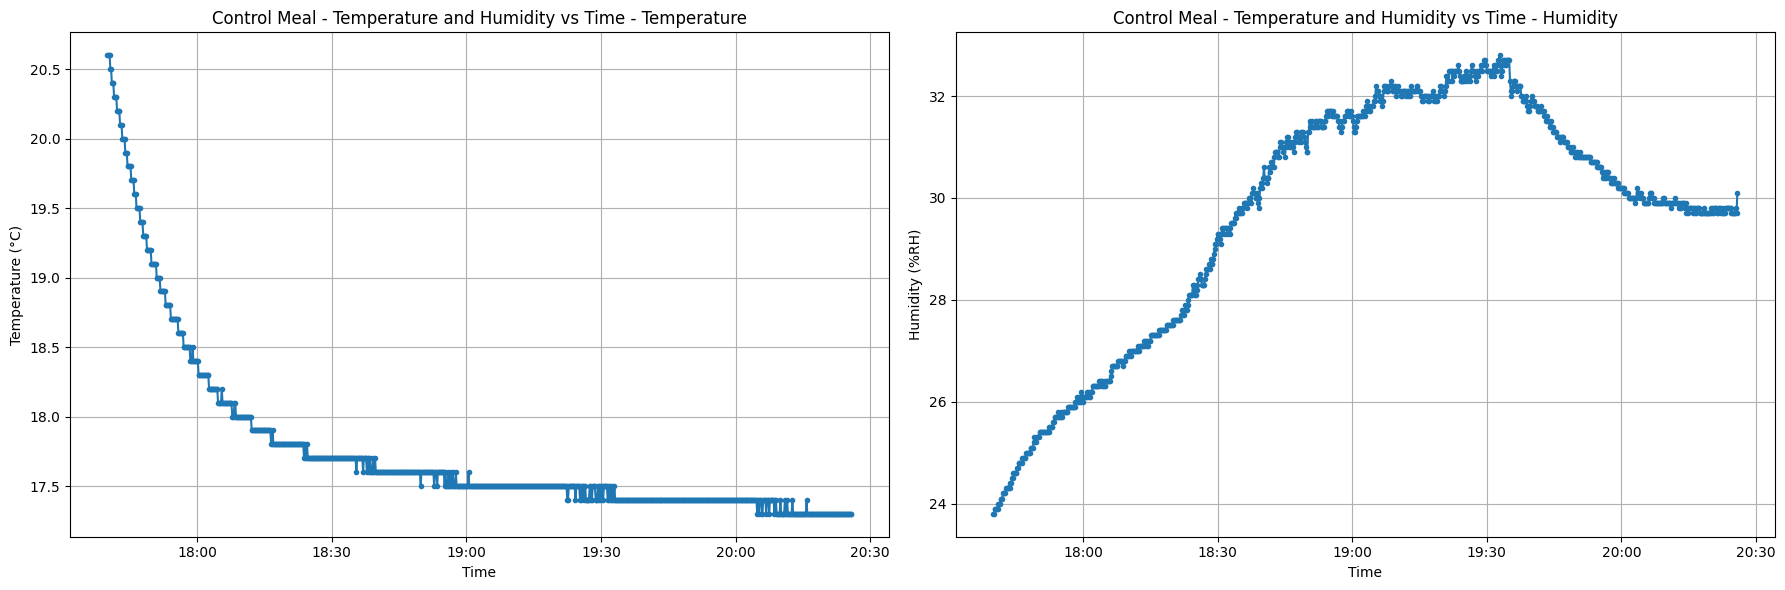

In [10]:
control_meal, measured_meal = [file for file in sorted(excel_files) if "11_29_meal" in file]
df_measured_meal, df_control_meal = df_lists[excel_files.index(measured_meal)], df_lists[excel_files.index(control_meal)]

print(measured_meal, control_meal)
print(len(df_measured_meal), len(df_control_meal))
print(df_measured_meal.head())

plot_data(df_measured_meal["Time"], df_measured_meal["Temperature"], df_measured_meal["Humidity"],
          marker='.', xlabel='Time', title='Measured Meal - Temperature and Humidity vs Time')

plot_data(df_control_meal["Time"], df_control_meal["Temperature"], df_control_meal["Humidity"],
          marker='.', xlabel='Time', title='Control Meal - Temperature and Humidity vs Time')

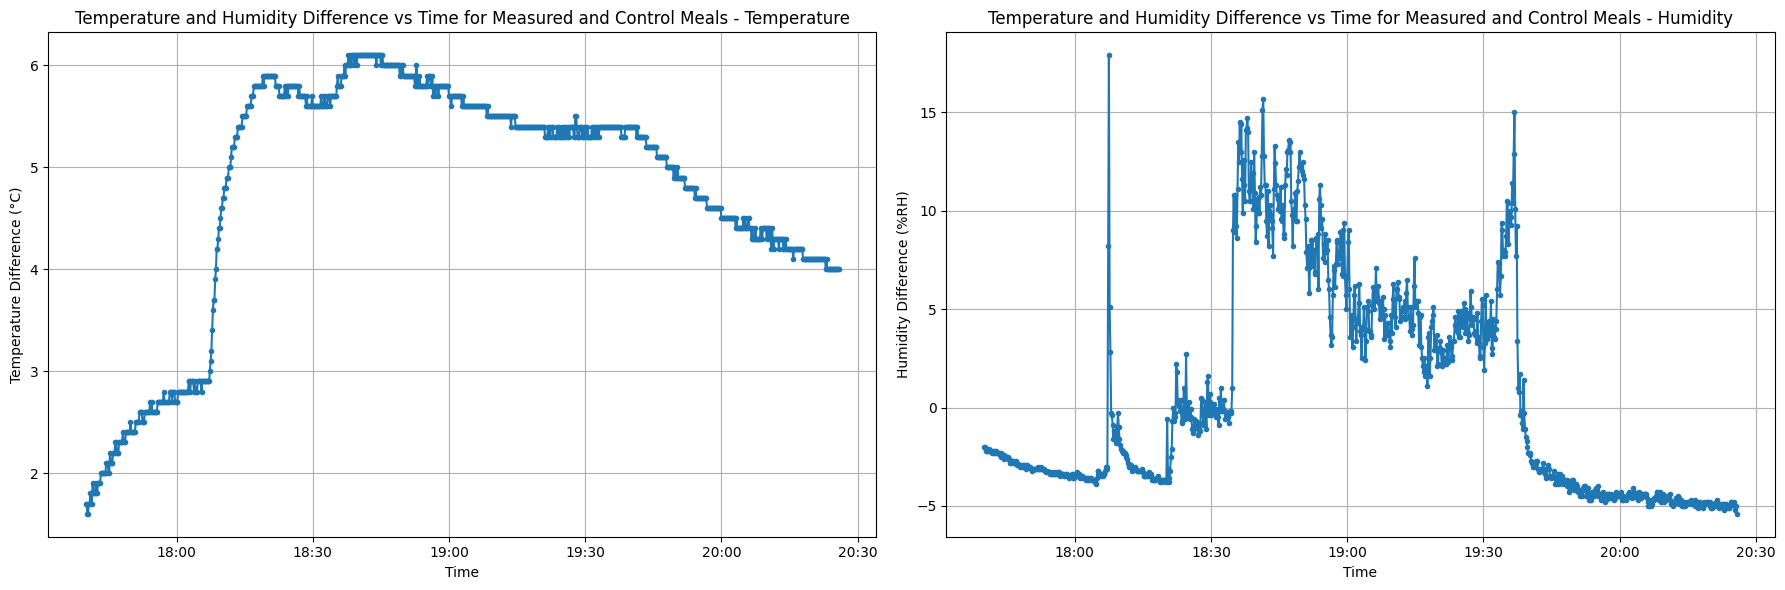

In [11]:
# Merge the dataframes on 'Time' column
df_merged = pd.merge(df_measured_meal, df_control_meal, on='Time', suffixes=('_measured', '_control'))

# Subtract the temperature and humidity data
df_merged['Temperature_diff'] = df_merged['Temperature_measured'] - df_merged['Temperature_control']
df_merged['Humidity_diff'] = df_merged['Humidity_measured'] - df_merged['Humidity_control']

# Select relevant columns and remove rows with NaN values
df_diff = df_merged[['Time', 'Temperature_diff', 'Humidity_diff']].dropna()

# Plot the temperature and humidity difference vs time using the plot_data function
plot_data(df_diff['Time'], df_diff['Temperature_diff'], df_diff['Humidity_diff'],
          marker='.', xlabel='Time', ylabel_temp='Temperature Difference (°C)', ylabel_humidity='Humidity Difference (%RH)',
          title='Temperature and Humidity Difference vs Time for Measured and Control Meals')

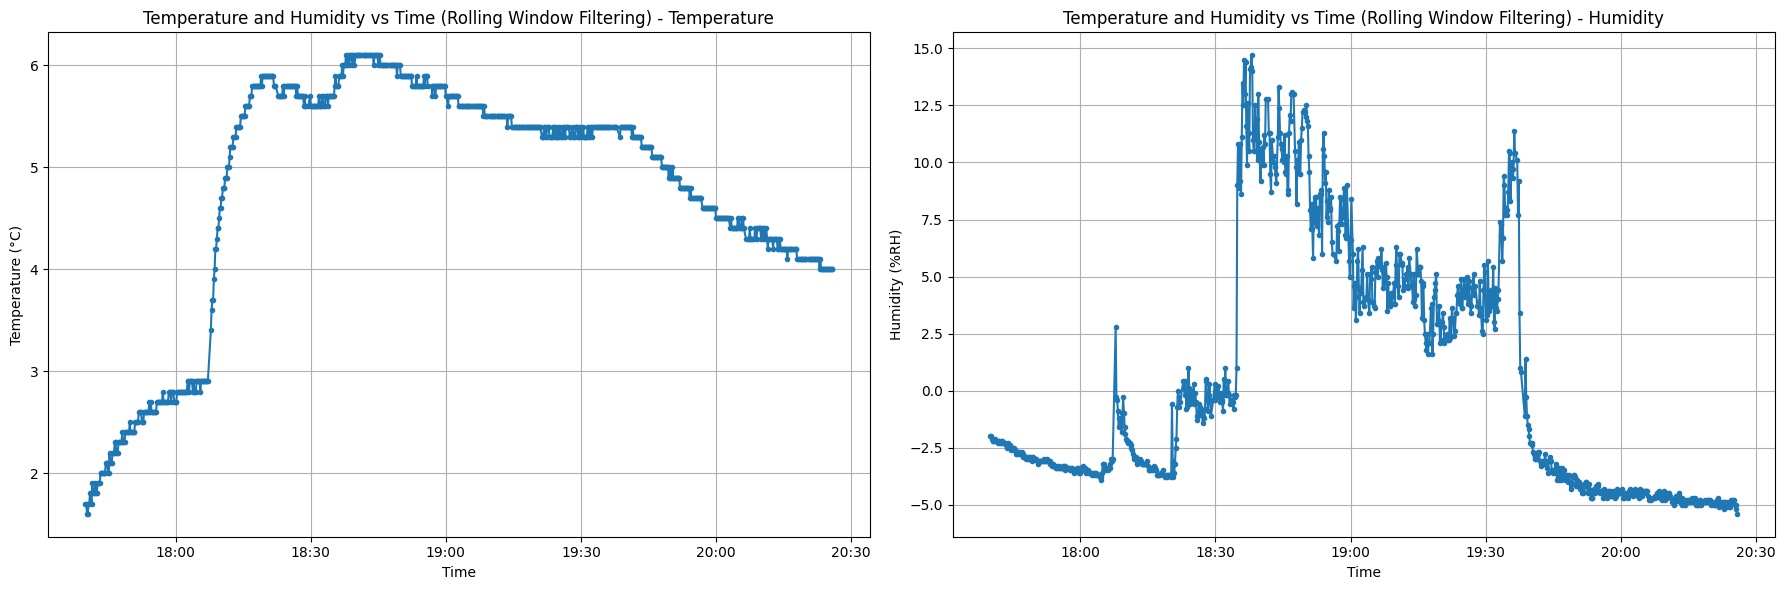

In [12]:
# Define the window size for the rolling statistics
window_size = 60
# Define the threshold for detecting spikes (e.g., 1.96 standard deviations from the mean, 95% CI)
threshold = 1.5

# Calculate the rolling mean and standard deviation for Temperature
rolling_mean_temp_diff = df_diff['Temperature_diff'].rolling(window=window_size, center=True).mean()
rolling_std_temp_diff = df_diff['Temperature_diff'].rolling(window=window_size, center=True).std()

# Calculate the rolling mean and standard deviation for Humidity
rolling_mean_humidity_diff = df_diff['Humidity_diff'].rolling(window=window_size, center=True).mean()
rolling_std_humidity_diff = df_diff['Humidity_diff'].rolling(window=window_size, center=True).std()

# Identify and remove spikes for Temperature
spikes_temp_diff = (df_diff['Temperature_diff'] - rolling_mean_temp_diff).abs() > (threshold * rolling_std_temp_diff)

# Identify and remove spikes for Humidity
spikes_humidity_diff = (df_diff['Humidity_diff'] - rolling_mean_humidity_diff).abs() > (threshold * rolling_std_humidity_diff)

# Remove spikes for both Temperature and Humidity
df_diff_no_spikes = df_diff[~(spikes_temp_diff | spikes_humidity_diff)]

# Plot the temperature and humidity vs time without spikes using the plot_data function
plot_data(df_diff_no_spikes["Time"], df_diff_no_spikes["Temperature_diff"], df_diff_no_spikes["Humidity_diff"],
          marker='.', xlabel='Time', title='Temperature and Humidity vs Time (Rolling Window Filtering)')


Steps to improve quality of data:

1. Place probes at two different places when no people are present and get their difference. This would be the correction factor for the probe placement.
3. Then, one can carry out the actual experiment and correct for the probe placement in this way.

# Analysis - Lounge Dataset

In [13]:
control_ambient, measured_ambient = [file for file in sorted(excel_files) if "ambient" in file]
control_live, measured_live = [file for file in sorted(excel_files) if "live" in file]

print(measured_ambient, control_ambient)
print(measured_live, control_live)

df_measured_ambient, df_control_ambient = df_lists[excel_files.index(measured_ambient)], df_lists[excel_files.index(control_ambient)]
df_measured_live, df_control_live = df_lists[excel_files.index(measured_live)], df_lists[excel_files.index(control_live)]

raw\11_30_nv_lounge_ambient_measured.xls raw\11_30_nv_lounge_ambient_control.xls
raw\12_1_nv_lounge_live_measured.xls raw\12_1_nv_lounge_live_control.xls


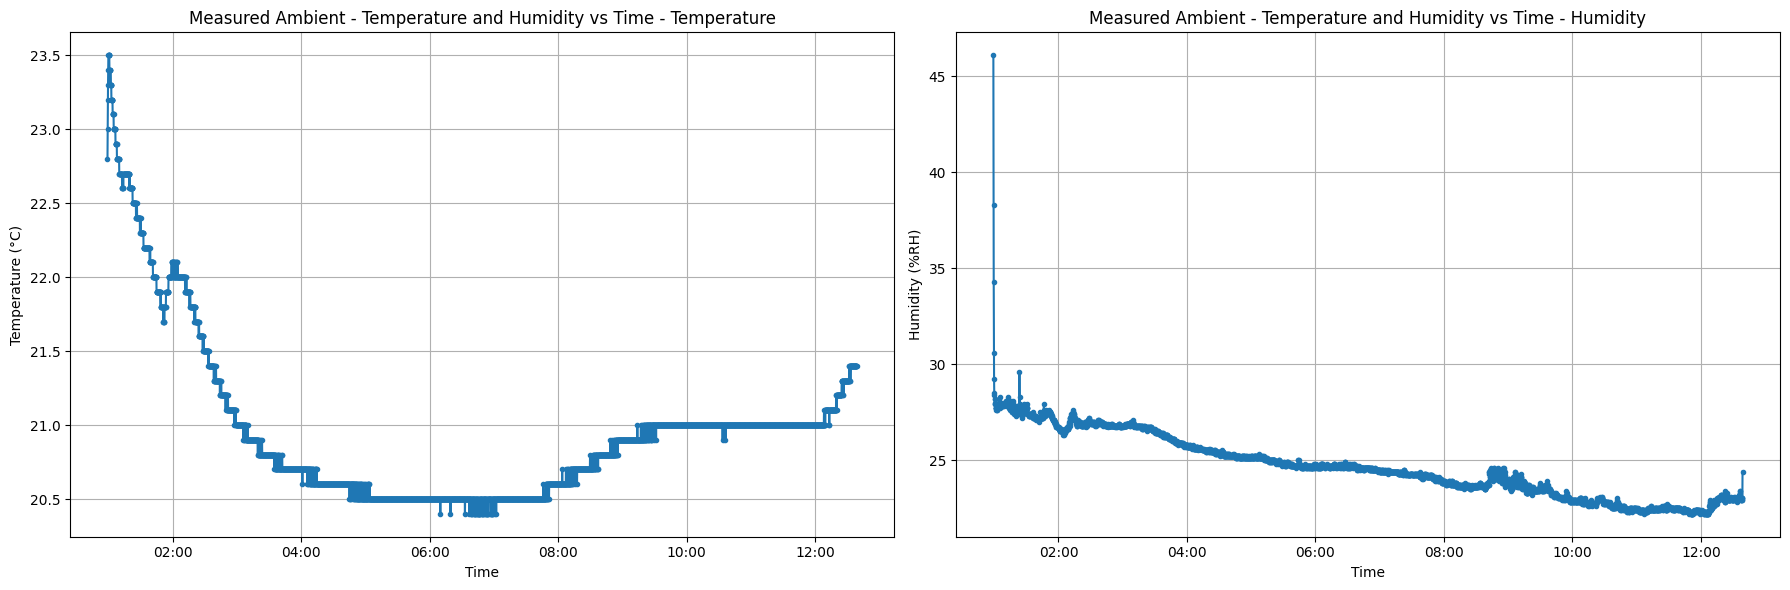

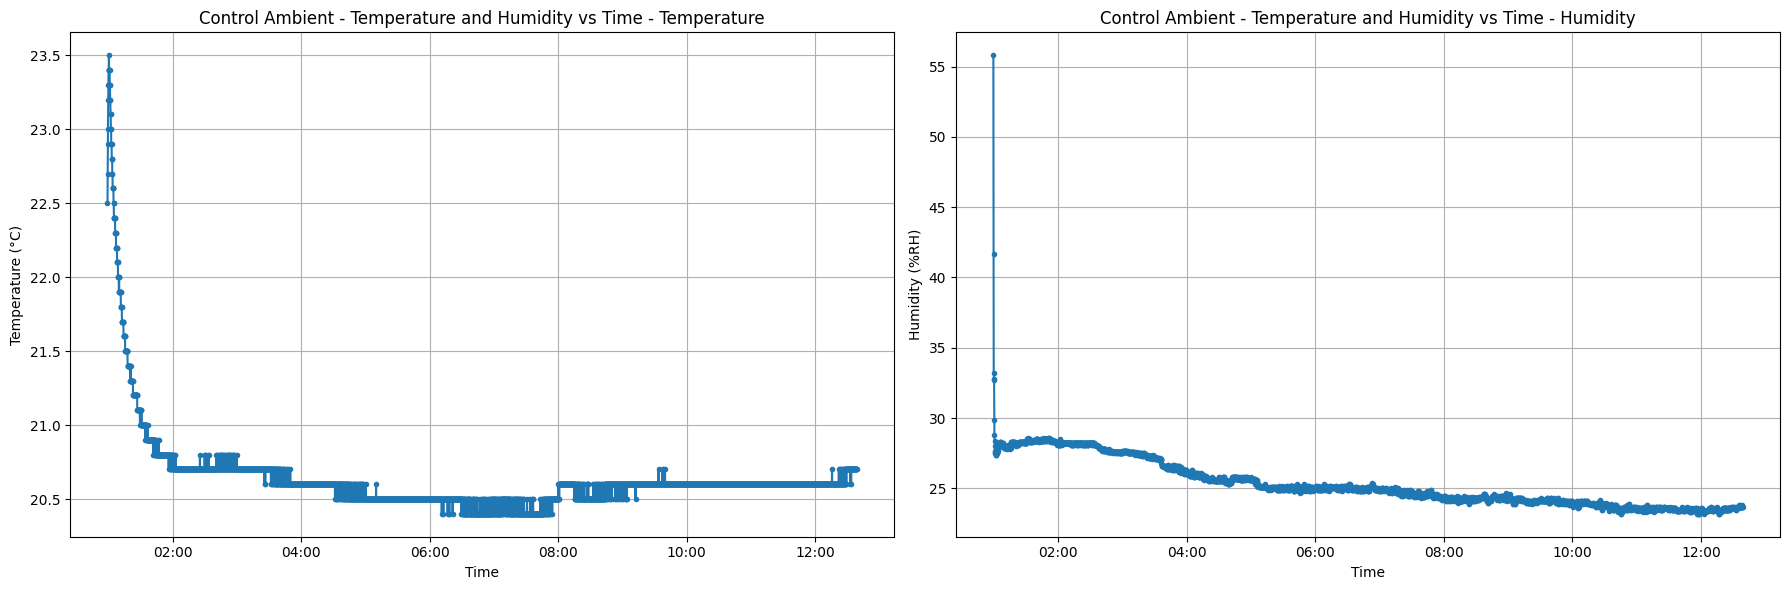

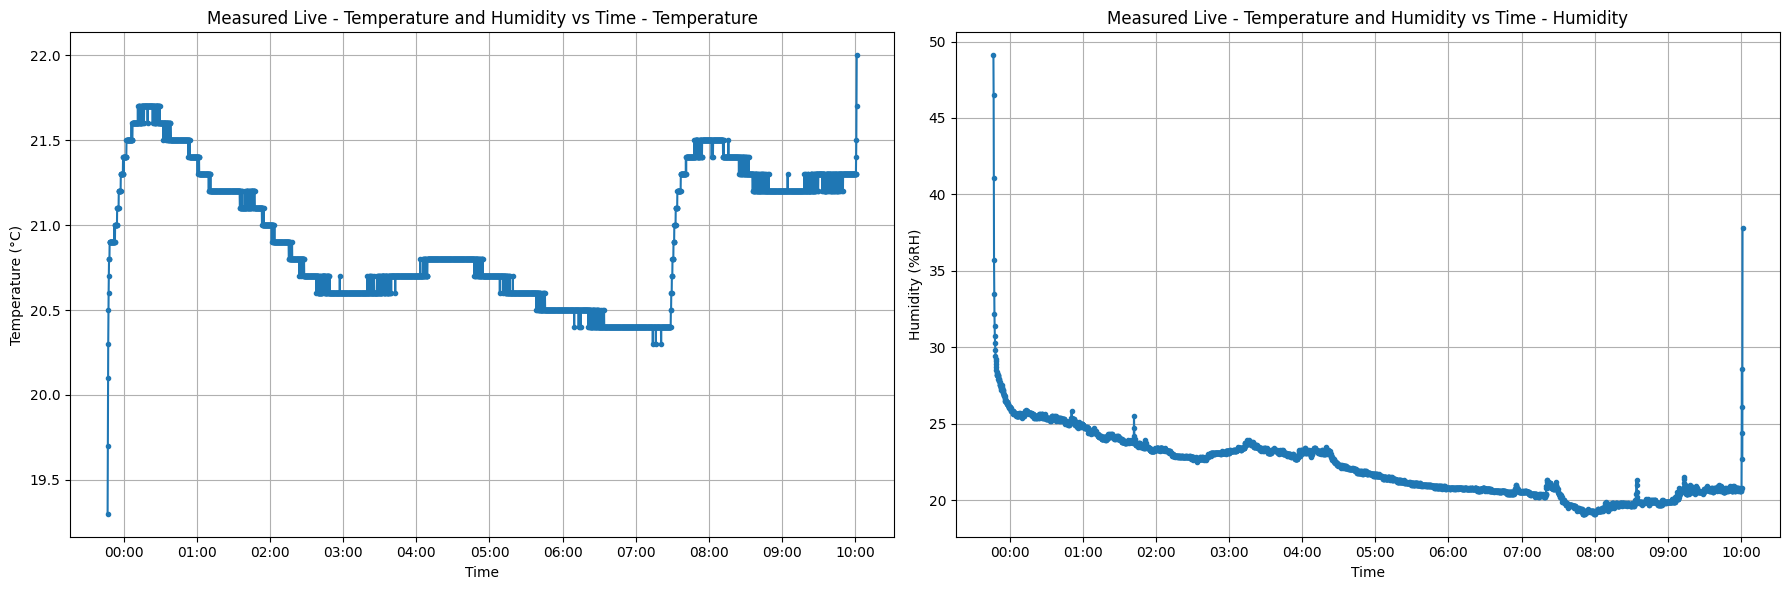

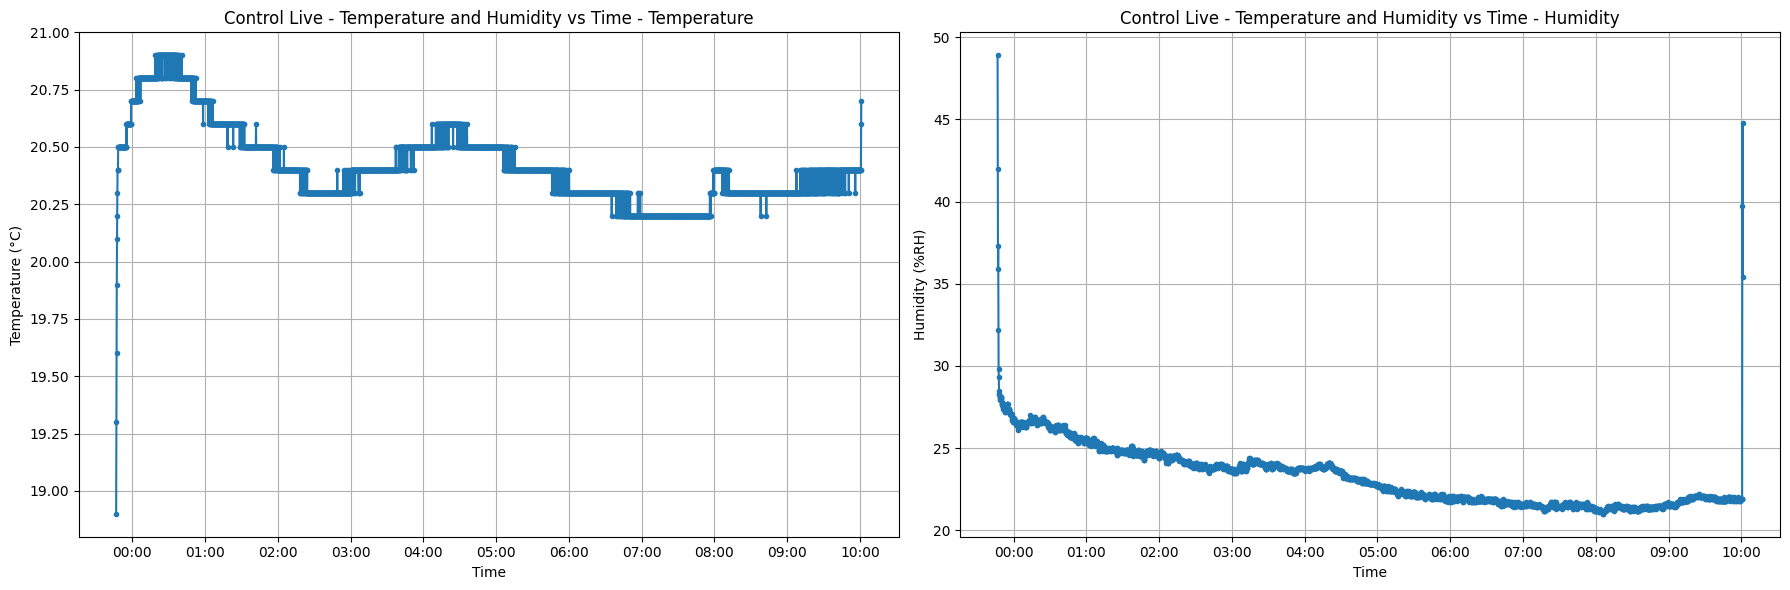

In [14]:
# Plot the measured ambient data
plot_data(df_measured_ambient["Time"], df_measured_ambient["Temperature"], df_measured_ambient["Humidity"],
          marker='.', xlabel='Time', title='Measured Ambient - Temperature and Humidity vs Time')

# Plot the control ambient data
plot_data(df_control_ambient["Time"], df_control_ambient["Temperature"], df_control_ambient["Humidity"],
          marker='.', xlabel='Time', title='Control Ambient - Temperature and Humidity vs Time')

# Plot the measured live data
plot_data(df_measured_live["Time"], df_measured_live["Temperature"], df_measured_live["Humidity"],
          marker='.', xlabel='Time', title='Measured Live - Temperature and Humidity vs Time')

# Plot the control live data
plot_data(df_control_live["Time"], df_control_live["Temperature"], df_control_live["Humidity"],
          marker='.', xlabel='Time', title='Control Live - Temperature and Humidity vs Time')

Get the "zero error correction", i.e. Zero Error = (Ambient Measured - Ambient Control)

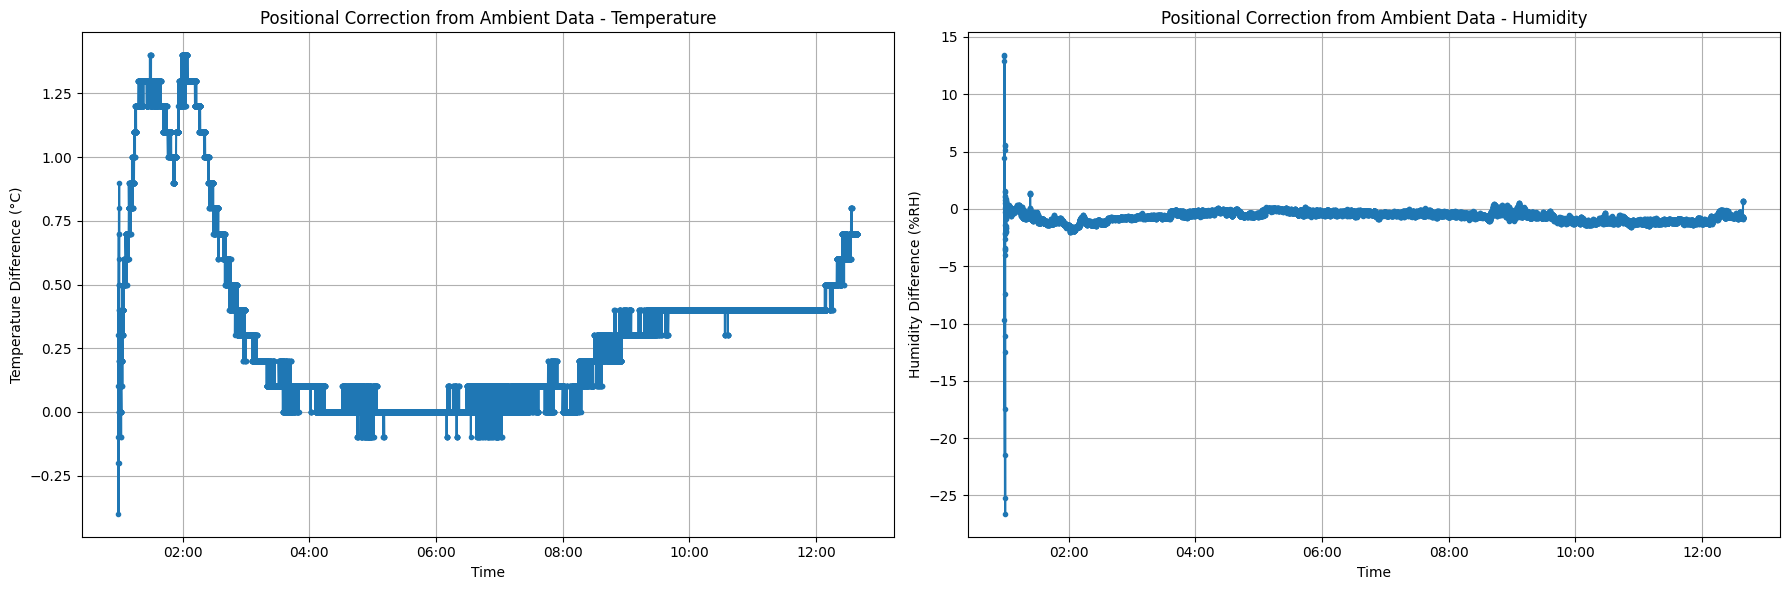

In [41]:
# Extract the hour and minute part from the 'Time' column
df_measured_ambient['Time_only'] = df_measured_ambient['Time'].dt.strftime('%H:%M')
df_control_ambient['Time_only'] = df_control_ambient['Time'].dt.strftime('%H:%M')

# Merge the control ambient and live dataframes on the 'Time_only' column
df_ambient_merged = pd.merge(df_measured_ambient, df_control_ambient, on='Time_only', suffixes=('_measured', '_control'))

# Subtract the temperature and humidity data
df_ambient_merged['Temperature_corr'] = df_ambient_merged['Temperature_measured'] - df_ambient_merged['Temperature_control']
df_ambient_merged['Humidity_corr'] = df_ambient_merged['Humidity_measured'] - df_ambient_merged['Humidity_control']

# Select relevant columns and remove rows with NaN values
df_ambient_correction = df_ambient_merged[['Time_measured', 'Temperature_corr', 'Humidity_corr']].dropna()

# Plot the temperature and humidity difference vs time using the plot_data function
plot_data(df_ambient_correction['Time_measured'], df_ambient_correction['Temperature_corr'], df_ambient_correction['Humidity_corr'],
          marker='.', xlabel='Time', ylabel_temp='Temperature Difference (°C)', ylabel_humidity='Humidity Difference (%RH)',
          title='Positional Correction from Ambient Data')

Actual Data = (Live Measured - Live Control) - Zero Error

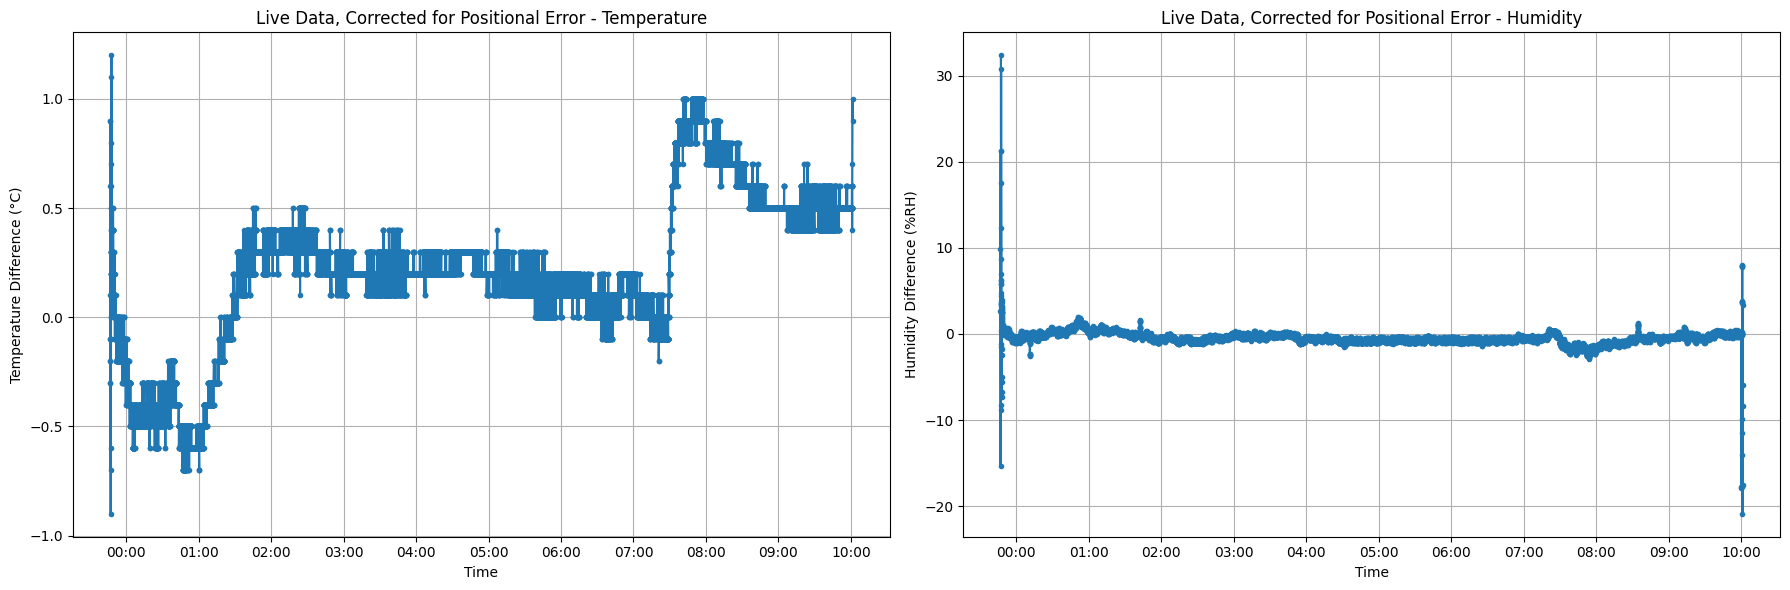

In [42]:
# Extract the hour and minute part from the 'Time' column
df_measured_live['Time_only'] = df_measured_live['Time'].dt.strftime('%H:%M')
df_control_live['Time_only'] = df_control_live['Time'].dt.strftime('%H:%M')

# Merge the live and ambient dataframes on the 'Time_only' column
df_live_merged = pd.merge(df_measured_live, df_control_live, on='Time_only', suffixes=('_measured', '_control'))

# Subtract the temperature and humidity data
df_live_merged['Temperature_data'] = (df_live_merged['Temperature_measured'] - df_live_merged['Temperature_control']) - df_ambient_correction['Temperature_corr']
df_live_merged['Humidity_data'] = (df_live_merged['Humidity_measured'] - df_live_merged['Humidity_control']) - df_ambient_correction['Humidity_corr']

# Select relevant columns and remove rows with NaN values
df_live_corrected = df_live_merged[['Time_measured', 'Temperature_data', 'Humidity_data']].dropna()

# Plot the temperature and humidity difference vs time using the plot_data function
plot_data(df_live_corrected['Time_measured'], df_live_corrected['Temperature_data'], df_live_corrected['Humidity_data'],
          marker='.', xlabel='Time', ylabel_temp='Temperature Difference (°C)', ylabel_humidity='Humidity Difference (%RH)',
          title='Live Data, Corrected for Positional Error')

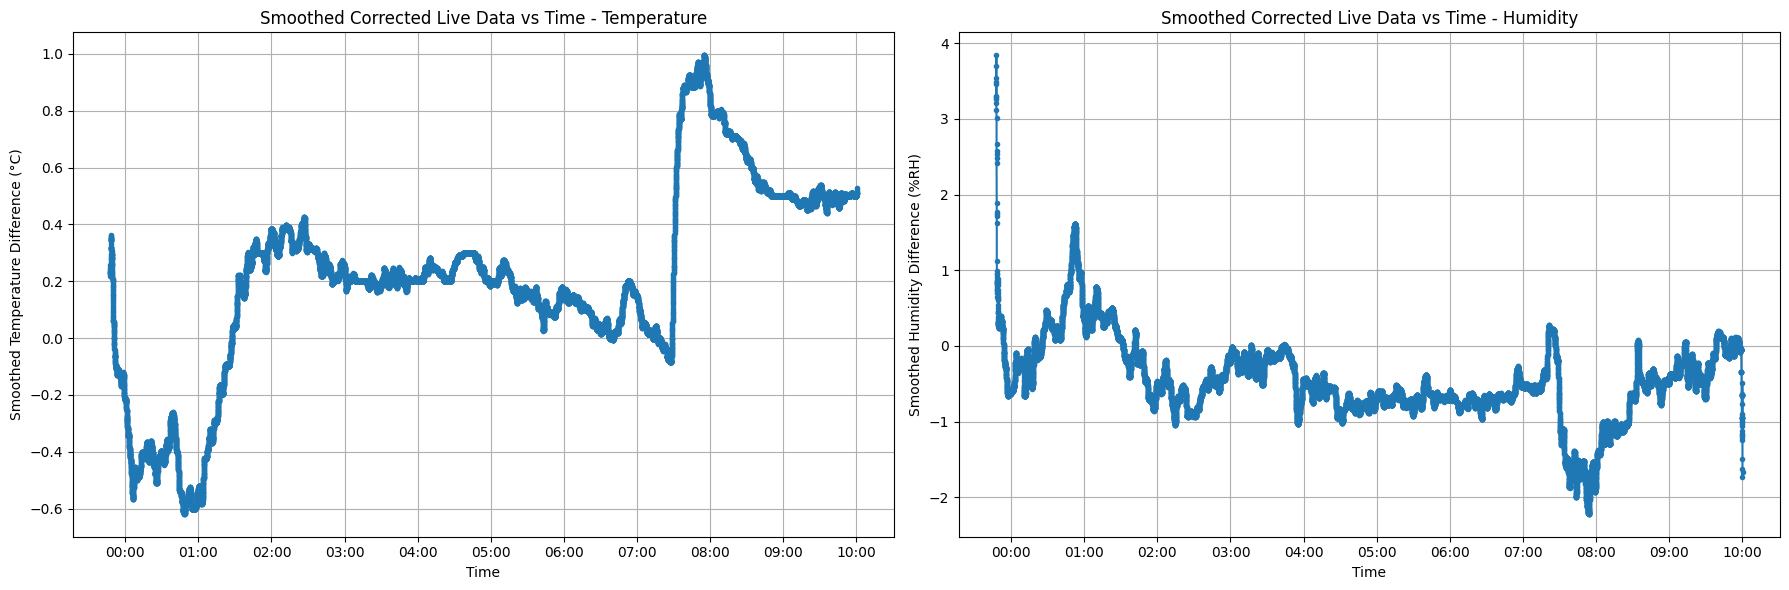

In [43]:
# Define the window size for the rolling statistics
window_size = 60

# Calculate the rolling mean for Temperature and Humidity differences
df_live_corrected['Temperature_data_smoothed'] = df_live_corrected['Temperature_data'].rolling(window=window_size, center=True).mean()
df_live_corrected['Humidity_data_smoothed'] = df_live_corrected['Humidity_data'].rolling(window=window_size, center=True).mean()

# Plot the smoothed temperature and humidity difference vs time using the plot_data function
plot_data(df_live_corrected['Time_measured'], df_live_corrected['Temperature_data_smoothed'], df_live_corrected['Humidity_data_smoothed'],
          marker='.', xlabel='Time', ylabel_temp='Smoothed Temperature Difference (°C)', ylabel_humidity='Smoothed Humidity Difference (%RH)',
          title='Smoothed Corrected Live Data vs Time')

[0.39578397 0.03390524 0.46679589]


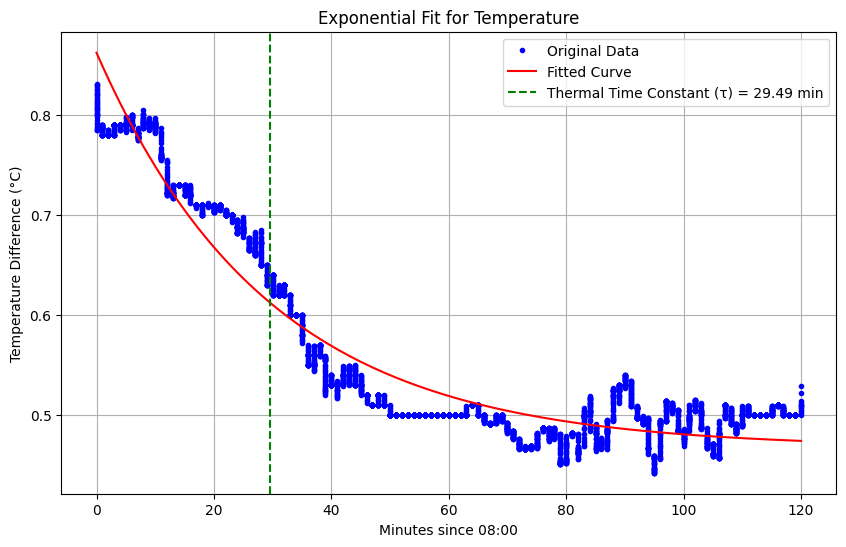

Thermal Time Constant (τ): 29.49 minutes


In [68]:
from scipy.optimize import curve_fit

# Define the exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Filter the dataframe for the specified interval
df_live_corrected['Time_only'] = df_live_corrected['Time_measured'].dt.strftime('%H:%M')
start_interval, end_interval = '08:00', '10:00'
df_interval = df_live_corrected.loc[(df_live_corrected["Time_only"] >= start_interval) & (df_live_corrected["Time_only"] <= end_interval)].copy()

# Convert start_interval to datetime
start_interval_dt = pd.to_datetime(start_interval, format='%H:%M')

# Convert time to minutes since the start of the interval
df_interval.loc[:, 'Minutes_since_2am'] = (pd.to_datetime(df_interval["Time_measured"].dt.strftime('%H:%M'), format='%H:%M') - start_interval_dt).dt.total_seconds() / 60

# Remove rows with NaN values
df_interval.dropna(subset=["Temperature_data_smoothed"], inplace=True)

temperature_diff = df_interval["Temperature_data_smoothed"].values

# Fit the exponential decay curve
popt, pcov = curve_fit(exp_decay, df_interval['Minutes_since_2am'], temperature_diff)
print(popt)

# Generate fitted temperature difference values
fitted_temperature_diff = exp_decay(df_interval['Minutes_since_2am'], *popt)

# Extract the decay rate parameter 'b' from the fitted parameters
decay_rate = popt[1]
# Calculate the thermal time constant (τ)
thermal_time_constant = 1 / decay_rate

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(df_interval['Minutes_since_2am'], temperature_diff, 'b.', label='Original Data')
plt.plot(df_interval['Minutes_since_2am'], fitted_temperature_diff, 'r-', label='Fitted Curve')
plt.axvline(x=thermal_time_constant, color='g', linestyle='--', label=f'Thermal Time Constant (τ) = {thermal_time_constant:.2f} min')
plt.xlabel(f'Minutes since {start_interval}')
plt.ylabel('Temperature Difference (°C)')
plt.title('Exponential Fit for Temperature')
plt.legend()
plt.grid(True)
plt.show()



print(f'Thermal Time Constant (τ): {thermal_time_constant:.2f} minutes')